In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, asc

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
engine.table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Getting column names
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [262]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from sqlalchemy import text

# Finding the last date in the data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# pulling date from a year earlier than the 8/23/2017 returned above
one_year_earlier = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Creating SQL query and dropping it into a dataframe

df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_earlier).\
    order_by(Measurement.date).all())

# Fix column names for upcoming graph
df.rename(columns = {'prcp': 'Precipitation', 'date': 'Date'}, inplace = True)

# Set Date as index
df.set_index('Date', inplace = True)
df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [263]:
# Sort the dataframe by date
df.sort_index(inplace = True)
df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


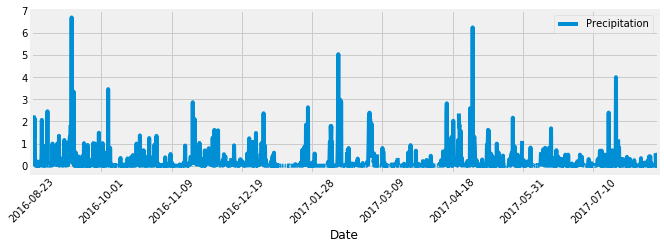

In [300]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = (10,3), rot = 45)

In [265]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [85]:
# Getting column names for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [216]:
# Design a query to show how many stations are available in this dataset
no_of_stations = session.query(Station.id).count()
print(f"There are {no_of_stations} stations in this dataset.")

There are 9 stations in this dataset.


In [366]:
station_names = session.query(Station.station).all()
[print(station.station) for station in station_names]

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


[None, None, None, None, None, None, None, None, None]

In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [329]:
# Get the most active station's number from the first tuple
most_active_station = most_active[0][0]
most_active_station

'USC00519281'

In [337]:
# Query specific to the most active station
temperatures = session.query(Measurement.station, 
                         func.min(Measurement.tobs), 
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs))\
                .filter(Measurement.station == most_active_station)\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()

temperatures

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [340]:
# Pulling values out of the tuple 
station_id = temperatures[0][0]
min_temp = temperatures[0][1]
max_temp = temperatures[0][2]
avg_temp = round(temperatures[0][3],2)

# Printout
print(f"Station {station_id} has a minimum temperature of {min_temp}, a maximum temperature of {max_temp},\n and an average temperature of {avg_temp}.")

Station USC00519281 has a minimum temperature of 54.0, a maximum temperature of 85.0,
 and an average temperature of 71.66.


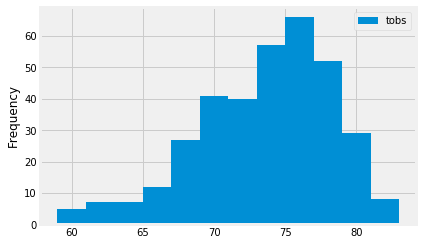

In [533]:
# Query the last 12 months of temperature observation data for the most active station and 
# plot the results as a histogram

temp_12_mos = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date > one_year_earlier).\
    order_by(Measurement.date).all())

temp_12_mos.plot.hist(bins=12)
plt.show()

In [130]:
# I'd like to make a dataframe of all the stations and their temperatures, so I'm pulling this data 
# with a more general query
temperatures = session.query(Measurement.station, 
                         func.min(Measurement.tobs), 
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()

In [131]:
# From the query above, these are ordered by most active station to least active station
temperatures

[('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00519523', 56.0, 85.0, 74.5436493068565),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784)]

In [196]:
# To drop these into a dataframe, I'll need to get the elements out of the tuples by calling them by position
# First I'll create empty lists for the columns
col1 = []
col2 = []
col3 = []
col4 = []

# Next I'll pull the elements using list comprehension
[col1.append(station[0]) for station in temperatures]
[col2.append(station[1]) for station in temperatures]
[col3.append(station[2]) for station in temperatures]

# Rounding the average temperature as it's appended
[col4.append(round(station[3],2)) for station in temperatures]

# To get a column of the activity, I can examine the most_active variable returned two queries above
col5 = []
[col5.append(station[1]) for station in most_active]

[None, None, None, None, None, None, None, None, None]

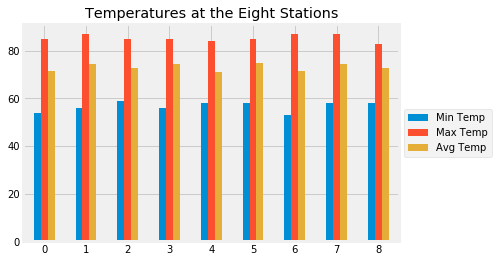

In [356]:
# Making a dataframe of the temperatures and doing a quick visualization

temps_df = pd.DataFrame()
temps_df["Station"] = col1
temps_df["Min Temp"] = col2
temps_df["Max Temp"] = col3
temps_df["Avg Temp"] = col4

# A quick visualization of temperatures
temps_df.plot.bar(title = "Temperatures at the Eight Stations", rot = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [344]:
# Adding the measurements column
temps_df["Observations"] = col5
temps_df.head()

,Station,Min Temp,Max Temp,Avg Temp,Measurements,Observations
0,USC00519281,54.0,85.0,71.66,2772,2772
1,USC00519397,56.0,87.0,74.55,2724,2724
2,USC00513117,59.0,85.0,72.69,2709,2709
3,USC00519523,56.0,85.0,74.54,2669,2669
4,USC00516128,58.0,84.0,70.92,2612,2612


In [186]:
# Making a dataframe of the stations table so I can merge it with the temperatures dataframe
stations_df = pd.read_sql("SELECT * FROM station", engine)
stations_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [346]:
# Combining temps with station table
temp_df = temps_df.rename(columns = {'Station': 'station'})
combined_df = pd.merge(temp_df, stations_df, on = 'station')

# Sorting by id and setting it as the index
combined_df.sort_values('id', inplace = True)
combined_df.set_index('id', inplace = True)

# Renaming columns
cols = {'station': 'Station', 'name': 'Name', 'latitude':'Latitude', 
        'longitude': 'Longitude', 'elevation': 'Elevation'}

combined_df = combined_df.rename(columns = cols)

# Reordering columns
col_order = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Observations', 'Min Temp',
            'Max Temp', 'Avg Temp']
combined_df = combined_df[col_order]

# Nice-looking dataframe
combined_df

,Station,Name,Latitude,Longitude,Elevation,Observations,Min Temp,Max Temp,Avg Temp
id,,,,,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2724,56.0,87.0,74.55
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2709,59.0,85.0,72.69
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2202,58.0,85.0,74.87
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1372,58.0,87.0,74.68
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,511,58.0,83.0,72.72
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2669,56.0,85.0,74.54
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2772,54.0,85.0,71.66
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1979,53.0,87.0,71.62
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2612,58.0,84.0,70.92


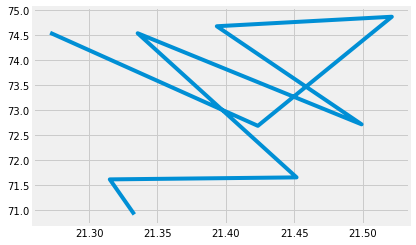

In [440]:
# This looks amazing. It's totally useless, but I just wanted to share it.
x = combined_df["Latitude"]
y = combined_df["Avg Temp"]
plt.plot(x,y)

In [243]:
# This function called `calc_temps` will accept start date and end date in the format
#'%Y-%m-%d'and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the fou rmat %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.sum(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [377]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Researching a trip with dates from June 20 - June 30

trip = (calc_temps('2017-06-20', '2017-06-30'))
tmin = trip[0][0]
tmax = trip[0][2]
tavg = round(trip[0][1],1)
print(f"Minimum temp is {tmin}, maximum temp is {tmax}, and average temp is {tavg}.")

Minimum temp is 71.0, maximum temp is 82.0, and average temp is 77.1.


In [404]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
title = "Trip Avg Temp"
# Use the average temperature for the y value
y = tavg
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin

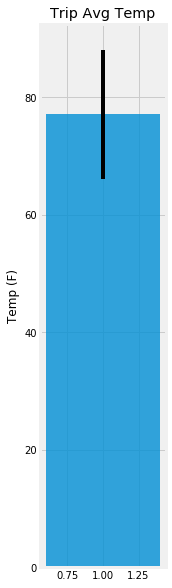

In [411]:
fig, ax = plt.subplots(figsize = (2,10))
ax.bar(1, y, yerr = yerr, alpha = 0.8)
ax.set_title(title)
ax.set_ylabel("Temp (F)")
plt.show()

In [417]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.

def rainfall(start_date, end_date):
    """Rainfall for a list of dates
    
    Args: 
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    
    Returns:
        total rainfall for each of 8 weather stations in Honolulu, Hawaii over the dates inputted
            """
    return session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).\
        all()          

In [430]:
# Sort this in descending order by precipitation amount and list the station, name, 
# latitude, longitude, and elevation

# First I will run the dates in the function I just made
rain = rainfall('2017-06-20', '2017-06-30')

# Next I will put them in a dataframe

# Columns start as empty lists
col1 = []
col2 = []

# List comprehensions to put the tuple results into lists
[col1.append(station[0]) for station in rain]
[col2.append(station[1]) for station in rain]

# Dataframe

quickdf = pd.DataFrame()
quickdf["station"] = col1
quickdf["rainfall"] = col2
quickdf

# Merge with stations_df

rainfall_df = pd.merge(quickdf, stations_df, on = 'station')
rainfall_df

,station,rainfall,id,name,latitude,longitude,elevation
0,USC00516128,2.49,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.83,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.35,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.17,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519397,0.16,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,0.12,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00517948,0.12,4,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [432]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [494]:
# Set the start date of the trip and its length
start = dt.date(2018, 6, 20)
length = 10

# Use the start and end date to create a range of dates
# The function below will produce the necessary dates and then strip them to month/day in separate lists
months = []
days = []

while length >= 0:
    months.append((start + dt.timedelta(days=length)).strftime("%m"))
    days.append((start + dt.timedelta(days=length)).strftime("%d"))
    length = length - 1

# Since I set up the while loop to put dates in reverse order, I'm fixing that here for future graphing    
months.reverse()
days.reverse()

# Matching up the months and days
dates = list(map(lambda x, y: x + '-' + y, months, days))
dates

['06-20',
 '06-21',
 '06-22',
 '06-23',
 '06-24',
 '06-25',
 '06-26',
 '06-27',
 '06-28',
 '06-29',
 '06-30']

In [500]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

for day in dates:
    normals.append(daily_normals(day))

In [521]:
normals

[[(68.0, 73.96491228070175, 85.0)],
 [(68.0, 74.75862068965517, 82.0)],
 [(69.0, 75.15789473684211, 81.0)],
 [(68.0, 74.54385964912281, 80.0)],
 [(68.0, 74.96428571428571, 84.0)],
 [(68.0, 74.10344827586206, 80.0)],
 [(67.0, 74.21428571428571, 82.0)],
 [(66.0, 75.01785714285714, 81.0)],
 [(69.0, 74.88679245283019, 80.0)],
 [(67.0, 74.91525423728814, 80.0)],
 [(67.0, 75.59615384615384, 81.0)]]

In [498]:
# Getting a list of days in desired form for the dataframe index
vacation_days = []
for day in dates:
    vacation_days.append('2018-'+ day)

In [522]:
# Preparing temperature data for dataframe
min_temp = []
avg_temp = []
max_temp = []

for normal in normals:
    min_temp.append(normal[0][0])
    avg_temp.append(round(normal[0][1],1))
    max_temp.append(normal[0][2])

In [523]:
# Making the dataframe for analysis
cols = {"date": vacation_days, "tmin": min_temp, "tavg": avg_temp, "tmax": max_temp}

vacation_df = pd.DataFrame(cols).set_index("date")

vacation_df.head()

,tmin,tavg,tmax
date,,,
2018-06-20,68.0,74.0,85.0
2018-06-21,68.0,74.8,82.0
2018-06-22,69.0,75.2,81.0
2018-06-23,68.0,74.5,80.0
2018-06-24,68.0,75.0,84.0


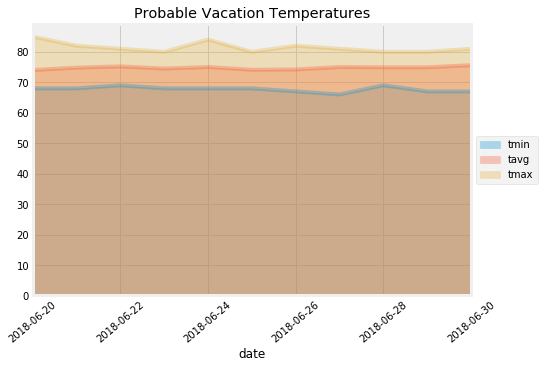

In [536]:
vacation_df.plot.area(stacked=False, figsize = (7,5), alpha = 0.3, rot = 40,
                      title = "Probable Vacation Temperatures")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()